# Bayesian SIR

Antonio Feltrin, Giosuè Sardo Infirri, Riccardo Tancredi, Simone Toso


## Scaletta
 - MCMC con un solo parametro

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.special import gamma as gammafunc
from scipy.stats import gamma as gammadist
from tqdm import tqdm

## Data generation

In [2]:
#Parameter initialization
N = int(1e6)
T = 101
I0 = 50

betas = 25*[0.3]+25*[.4]+25*[.25]+26*[.2]
gammas = 25*[0.05]+25*[.1]+25*[.15]+26*[.25]

betas = betas + betas
gammas = gammas + gammas

#Simulation
initial_conf = np.array([N-I0, I0, 0])

configurations = np.zeros([T, 3])
configurations[0, :] = initial_conf

for tt in range(1, T):
    beta_true = betas[tt]
    gamma_true = gammas[tt]
    
    delta_I = npr.binomial(configurations[tt-1][0],
                           1 - np.exp(-beta_true*configurations[tt-1][1]/N))
    delta_R = npr.binomial(configurations[tt-1][1],
                           gamma_true)
    configurations[tt][0] = configurations[tt-1][0] - delta_I
    configurations[tt][1] = configurations[tt-1][1] + delta_I - delta_R
    configurations[tt][2] = configurations[tt-1][2] + delta_R

Text(0.5, 1.0, 'Simulated data with varying parameters')

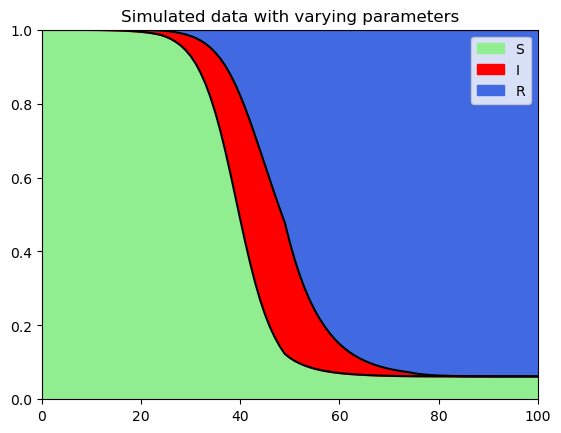

In [3]:
xs = np.arange(0, T)
ss = configurations[:, 0] / N
ii = configurations[:, 1]/N + ss
rr = configurations[:, 2]/N + ii

plt.plot(ss, c = "black")
plt.plot(ii, c = "black")
plt.plot(rr, c = "black")
plt.ylim([0, 1])

plt.fill_between(xs, 0, ss, label = "S", color = "lightgreen")
plt.fill_between(xs, ss, ii, label = "I", color = "red")
plt.fill_between(xs, ii, rr, label = "R", color = "royalblue")

plt.xlim([0, T-1])
plt.legend()
plt.title("Simulated data with varying parameters")

In [4]:
configurations[:, 1]

array([5.00000e+01, 6.40000e+01, 8.40000e+01, 1.08000e+02, 1.28000e+02,
       1.53000e+02, 1.95000e+02, 2.49000e+02, 3.12000e+02, 3.89000e+02,
       4.77000e+02, 6.17000e+02, 7.88000e+02, 9.80000e+02, 1.25300e+03,
       1.58200e+03, 1.95800e+03, 2.42500e+03, 3.08700e+03, 3.84900e+03,
       4.79900e+03, 6.00200e+03, 7.55100e+03, 9.46200e+03, 1.18640e+04,
       1.54380e+04, 2.00330e+04, 2.59230e+04, 3.32120e+04, 4.26180e+04,
       5.42490e+04, 6.89360e+04, 8.72310e+04, 1.08584e+05, 1.34130e+05,
       1.63206e+05, 1.95411e+05, 2.30890e+05, 2.67338e+05, 3.02511e+05,
       3.34914e+05, 3.62321e+05, 3.83469e+05, 3.97392e+05, 4.04199e+05,
       4.03943e+05, 3.97772e+05, 3.86428e+05, 3.71948e+05, 3.54670e+05,
       3.11654e+05, 2.73238e+05, 2.38589e+05, 2.08588e+05, 1.81816e+05,
       1.58837e+05, 1.38356e+05, 1.20484e+05, 1.04601e+05, 9.08660e+04,
       7.87840e+04, 6.83220e+04, 5.92530e+04, 5.13730e+04, 4.44500e+04,
       3.85790e+04, 3.34620e+04, 2.89920e+04, 2.51360e+04, 2.177

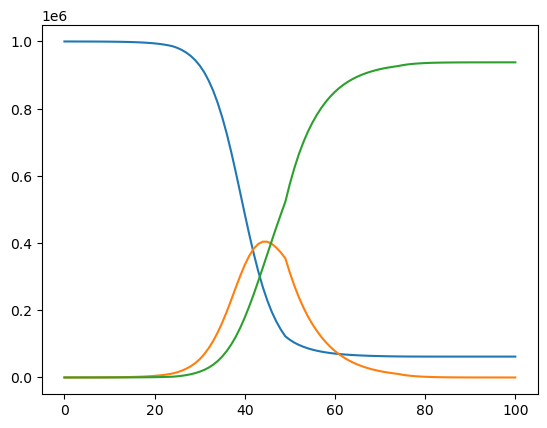

In [5]:
plt.plot(configurations[:, 0])
plt.plot(configurations[:, 1])
plt.plot(configurations[:, 2])

# MCMC functions definition


In [6]:
def mylog(x):
    try:
        x = np.array(x)
        mask = x > 0
        output = np.zeros(len(x))
        output[mask] = np.log(x[mask])
        output[~mask] = -1022
        return output
    except:
        return np.log(x) if x > 0 else -1022

### Delta update

In [7]:
def conditional_betagamma_old(delta, beta, gamma):
    K = np.sum(delta).astype(int)
    eta = np.cumsum(delta)
    total = 0
    for ii in range(K):
        indic = eta == ii
        total += 2*mylog(gammafunc(0.1 + np.sum(indic)))
        total -= mylog(0.1 + np.sum(beta*(indic)))*(0.1 + np.sum(indic))
        total -= mylog(0.1 - np.sum(mylog(gamma)*(indic)))*(0.1 + np.sum(indic))
    return total

def conditional_betagamma(delta, beta, gamma):
    K = np.sum(delta).astype(int)
    eta = np.cumsum(delta)
    total = 0
    for ii in range(K):
        indic = eta == ii
        total = total + 0.2*np.log(0.1) - 2*np.log(gammafunc(0.1))
        total = total + 2*mylog(gammafunc(0.1 + np.sum(indic))) - np.sum(indic*mylog(gamma))
        total = total - (0.1+np.sum(indic))*(mylog(.1 + np.sum(indic*beta)) + mylog(0.1 - np.sum(indic*mylog(gamma))))
    return total

def JJ(delta_proposed, delta_now, T):
    
    sum_proposed = np.sum(delta_proposed).astype(int)
    sum_now = np.sum(delta_now).astype(int)
    
    if sum_proposed == sum_now:
        return 1
    elif [sum_proposed, sum_now] == [1, 2] or [sum_proposed, sum_now] == [T, T-1]:
        return 3/(T-1)
    elif [sum_proposed, sum_now] == [2, 1] or [sum_proposed, sum_now] == [T-1, T]:
        return (T-1)/3
    elif sum_proposed < sum_now:
        return (sum_now - 1)/(T-sum_proposed)
    else:
        return (T- sum_now) / (sum_proposed - 1)
    
def update_delta(delta_proposed, delta_now, beta_now, gamma_now, p, T):
    #Step 1: evaluate first term pi/pi
    difference = np.sum(delta_proposed - delta_now)
    first_term = difference*mylog(p/(1-p))
    
    #Step 2: evaluate second term:
    second_term = conditional_betagamma(delta_proposed, beta_now, gamma_now)
    second_term -= conditional_betagamma(delta_now, beta_now, gamma_now)
    
    #Step 3: evaluate third term
    third_term = mylog(JJ(delta_proposed, delta_now, T))
    
    log_m = first_term + second_term + third_term
        
    probability = min(0, log_m)
    
        
    eps = np.log(npr.uniform()) 
   # print(f"eps {eps}")
    if eps < probability:
        return delta_proposed
    else:
        return delta_now
    
def propose_delta(delta_now, T):
    delta = delta_now.copy()
    K = np.sum(delta).astype(int)
    if K == 1:
        probs = np.array([1,0,0])
    elif K==T:
        probs = np.array([0,1,0])
    else:
        probs = np.array([1,1,1])/3
        
    choice = npr.choice([0,1,2], p = probs)
    
    if choice == 0: #add
        index = npr.choice(np.where(delta_now == 0)[0])
        delta[index] += 1
    elif choice == 1: #delete
        index = npr.choice(np.where(delta_now[1:] == 1)[0]) + 1
        delta[index] -= 1
    else: #swap
        candidates = np.where((delta_now[1:T-1] - delta_now[2:T]) != 0)[0] + 1
        index_0 = npr.choice(candidates)
        delta[index_0] = 1 - delta[index_0]
        delta[index_0+1] = 1 - delta[index_0+1]

    
    return delta  

### b and r update

In [8]:
def update_b(delta_now, beta_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    b_next = np.zeros(K)
    for kk in range(K):
        b_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1+np.sum(beta_now*(eta==kk))))
    return b_next

def update_r(delta_now, gamma_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    r_next = np.zeros(K)
    for kk in range(K):
        r_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1 + np.sum(-mylog(gamma_now)*(eta==kk))))

    return r_next

### Update beta and gamma

In [64]:
#For each beta find a sample from posterior
def update_beta(S, I, N, T, b): #cool beta distribution trick
    new_betas = np.zeros(T)
    for tt in range(T):
        C = I[tt]/N
        D = -S[tt+1]+S[tt]
        A = C*(S[tt]-D)+b[tt]
       # print(f"A {A},C {C},D {D}")
        if C > 1e-4:
            y = npr.beta(a = A/C, b = D+1)
            new_betas[tt] = -1/C*np.log(y)
        else:
            y = npr.exponential(scale=1/(b[tt] + I[tt]*S[tt]/N))
            new_betas[tt] = y
        
    return new_betas

def update_gamma(I, R, N, T, r):
    new_gammas = np.zeros(T)
    for tt in range(T):
        delta_R = R[tt+1]-R[tt]
        new_gammas[tt] = npr.beta(delta_R + r[tt], I[tt]-delta_R+1)
    return new_gammas

In [65]:
configurations[:,1]/N

array([5.00000e-05, 6.40000e-05, 8.40000e-05, 1.08000e-04, 1.28000e-04,
       1.53000e-04, 1.95000e-04, 2.49000e-04, 3.12000e-04, 3.89000e-04,
       4.77000e-04, 6.17000e-04, 7.88000e-04, 9.80000e-04, 1.25300e-03,
       1.58200e-03, 1.95800e-03, 2.42500e-03, 3.08700e-03, 3.84900e-03,
       4.79900e-03, 6.00200e-03, 7.55100e-03, 9.46200e-03, 1.18640e-02,
       1.54380e-02, 2.00330e-02, 2.59230e-02, 3.32120e-02, 4.26180e-02,
       5.42490e-02, 6.89360e-02, 8.72310e-02, 1.08584e-01, 1.34130e-01,
       1.63206e-01, 1.95411e-01, 2.30890e-01, 2.67338e-01, 3.02511e-01,
       3.34914e-01, 3.62321e-01, 3.83469e-01, 3.97392e-01, 4.04199e-01,
       4.03943e-01, 3.97772e-01, 3.86428e-01, 3.71948e-01, 3.54670e-01,
       3.11654e-01, 2.73238e-01, 2.38589e-01, 2.08588e-01, 1.81816e-01,
       1.58837e-01, 1.38356e-01, 1.20484e-01, 1.04601e-01, 9.08660e-02,
       7.87840e-02, 6.83220e-02, 5.92530e-02, 5.13730e-02, 4.44500e-02,
       3.85790e-02, 3.34620e-02, 2.89920e-02, 2.51360e-02, 2.177

# Let's try a full run

In [66]:
n_steps = int(15000)

p = 0.1
T = 100

burnin = 5000
thin = 10

betas_run = np.zeros([T, n_steps])
gammas_run = np.zeros([T, n_steps])
bs_run = np.zeros([T, n_steps])
rs_run = np.zeros([T, n_steps])
deltas_run = np.zeros([T, n_steps])


# Initialize parameters
delta_0 = (npr.uniform(size = T) < p).astype(int)
delta_0[0] = 1

KK = np.sum(delta_0)
eta = np.cumsum(delta_0)
rb = npr.gamma(shape = .1, scale = 10, size = (2,KK))
r_0 = rb[0]
b_0 = rb[1]

r_0 = r_0[eta-1]
b_0 = b_0[eta-1]

beta_0 = npr.exponential(1/b_0)
gamma_0 = npr.beta(r_0, 1)

delta = delta_0.copy()
beta = beta_0.copy()
gamma = gamma_0.copy()
r = r_0.copy()
b = b_0.copy()


for step in tqdm(range(n_steps), desc='Buffering...', colour='green'):
    if step%1000 == 0:
        print(step)
    
    delta_new = propose_delta(delta, T)
    delta = update_delta(delta_new, delta, beta, gamma, p, T)

    b = update_b(delta, beta)
    r = update_r(delta, gamma)

    eta = np.cumsum(delta)
    b = b[eta-1]
    r = r[eta-1]
    
    beta = update_beta(configurations[:,0], configurations[:,1], N, T, b)
    gamma = update_gamma(configurations[:,1], configurations[:,2], N, T, r)
    
    if step >= burnin and step % 1 == 0:
        betas_run[:, step] = beta
        gammas_run[:,step] = gamma
        deltas_run[:,step] = delta
        bs_run[:,step] = b
        rs_run[:,step] = r
    
    

Buffering...:   1%|▏                       | 133/15000 [00:00<00:21, 684.48it/s]

0


Buffering...:   7%|█▋                     | 1119/15000 [00:01<00:15, 897.56it/s]

1000


Buffering...:  14%|███▎                   | 2149/15000 [00:02<00:14, 859.37it/s]

2000


Buffering...:  21%|████▊                  | 3162/15000 [00:03<00:13, 880.90it/s]

3000


Buffering...:  27%|██████▏                | 4031/15000 [00:04<00:11, 970.65it/s]

4000


Buffering...:  34%|███████▉               | 5139/15000 [00:06<00:15, 656.58it/s]

5000


Buffering...:  41%|█████████▍             | 6140/15000 [00:08<00:11, 792.29it/s]

6000


Buffering...:  47%|██████████▉            | 7100/15000 [00:09<00:09, 856.06it/s]

7000


Buffering...:  54%|████████████▌          | 8174/15000 [00:10<00:06, 991.81it/s]

8000


Buffering...:  61%|██████████████         | 9208/15000 [00:11<00:05, 992.66it/s]

9000


Buffering...:  68%|██████████████▎      | 10208/15000 [00:12<00:04, 1103.75it/s]

10000


Buffering...:  74%|███████████████▌     | 11088/15000 [00:13<00:03, 1049.01it/s]

11000


Buffering...:  81%|█████████████████▊    | 12160/15000 [00:14<00:03, 921.83it/s]

12000


Buffering...:  88%|███████████████████▎  | 13148/15000 [00:15<00:02, 789.90it/s]

13000


Buffering...:  94%|████████████████████▋ | 14144/15000 [00:17<00:00, 914.88it/s]

14000


Buffering...: 100%|██████████████████████| 15000/15000 [00:18<00:00, 827.70it/s]


## Bayesian estimators

In [67]:
#Keep column which are not empty

deltas_samples = deltas_run[:, burnin::thin]
bs_samples = bs_run[:, burnin::thin]
rs_samples = rs_run[:, burnin::thin]
betas_samples = betas_run[:, burnin::thin]
gammas_samples = gammas_run[:, burnin::thin]

In [68]:
#Every row is a timestep
beta_mean = np.mean(betas_samples, axis = 1)
beta_mean

array([0.02012402, 0.01510751, 0.011238  , 0.28413503, 0.24531058,
       0.32020303, 0.3378965 , 0.30234926, 0.29829546, 0.2963895 ,
       0.33943605, 0.33530955, 0.28986071, 0.31900484, 0.31220934,
       0.29344501, 0.28888494, 0.31685076, 0.2963274 , 0.30260213,
       0.3025668 , 0.31253098, 0.30667245, 0.30804586, 0.40173331,
       0.40293103, 0.40807919, 0.3972664 , 0.40209452, 0.39868281,
       0.40152712, 0.40640984, 0.39726924, 0.40125661, 0.39826119,
       0.39654158, 0.40251505, 0.401637  , 0.40052621, 0.40128561,
       0.39995104, 0.40049385, 0.40145816, 0.4010884 , 0.39729277,
       0.40034364, 0.39610006, 0.40282675, 0.40695835, 0.2506742 ,
       0.25096409, 0.24377957, 0.24978358, 0.25102472, 0.2529243 ,
       0.24886016, 0.25277422, 0.24577613, 0.25673414, 0.24306602,
       0.24442507, 0.24511648, 0.23595058, 0.24417468, 0.25147188,
       0.2482092 , 0.25464712, 0.24771726, 0.25138903, 0.26173548,
       0.24713829, 0.26983395, 0.23935929, 0.24257929, 0.17510

In [69]:
beta = np.mean(betas_samples, axis = 1)
beta_mean.reshape(4, 25).mean(axis=1)

array([0.27426116, 0.39493883, 0.24618162, 0.21626728])

In [70]:
gamma = np.mean(gammas_samples, axis = 1)
gamma.reshape(4, 25).mean(axis=1)
#plt.plot(gamma)

array([0.05714901, 0.10191435, 0.15373063, 0.25266164])

In [71]:
gamma

array([0.05568843, 0.10350379, 0.04541263, 0.09781602, 0.05275235,
       0.04988238, 0.06003765, 0.05125245, 0.05060914, 0.0715415 ,
       0.04766638, 0.05820787, 0.04672136, 0.04034242, 0.0495636 ,
       0.05499809, 0.04948643, 0.04353503, 0.04822247, 0.05452035,
       0.05028577, 0.05187196, 0.05059979, 0.05011939, 0.09408789,
       0.09664514, 0.10227487, 0.10102024, 0.09907047, 0.10046785,
       0.09815663, 0.09864569, 0.10010833, 0.09975226, 0.10008828,
       0.10013303, 0.09941032, 0.09957294, 0.10071047, 0.10056005,
       0.10036756, 0.10031187, 0.10072783, 0.09990574, 0.09941431,
       0.09996799, 0.09999154, 0.09959419, 0.10029057, 0.15067069,
       0.15032769, 0.15125397, 0.14929384, 0.15067908, 0.147845  ,
       0.14914283, 0.14892496, 0.15043787, 0.15022556, 0.150393  ,
       0.14998225, 0.14968499, 0.14906655, 0.15117833, 0.14872508,
       0.1488923 , 0.1502196 , 0.14895429, 0.14965005, 0.1534209 ,
       0.14738915, 0.14753669, 0.14943049, 0.15478115, 0.24582

In [72]:
deltas_run[:, (np.sum(deltas_run, axis = 0)) > 3]#[:, -2]

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
deltas_samples#.shape

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [74]:
etas_samples = np.cumsum(deltas_samples, axis=0)

In [75]:
etas_samples

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [4., 3., 1., ..., 3., 3., 2.],
       [4., 4., 2., ..., 3., 3., 2.],
       [4., 4., 2., ..., 3., 3., 2.]])

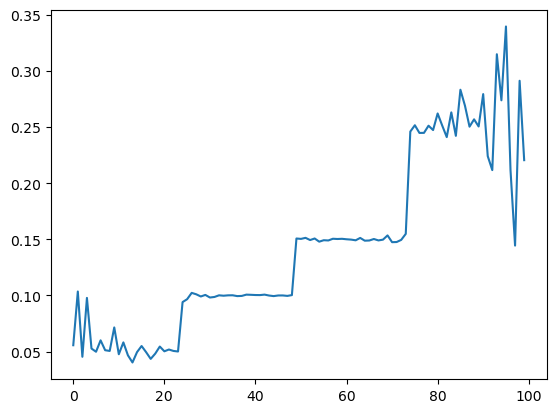

In [76]:
plt.plot(gamma)

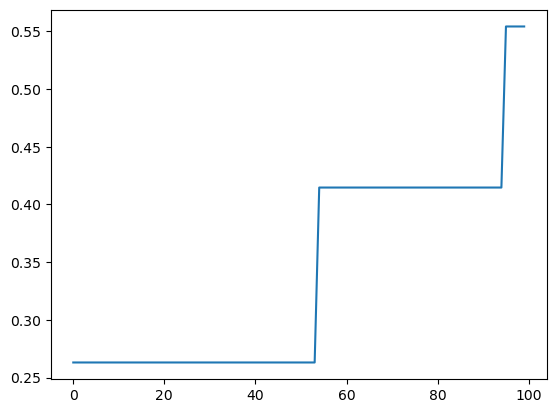

In [77]:
plt.plot(rs_samples[:,27])

In [78]:
rs_samples.shape

(100, 1000)

In [79]:
rs_samples[:,4]

array([5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
       5.31936077e-09, 5.31936077e-09, 5.31936077e-09, 5.31936077e-09,
      

(array([1077.,   10.,   24.,   15.,   45.,   71.,   84.,   64.,   48.,
        1040.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

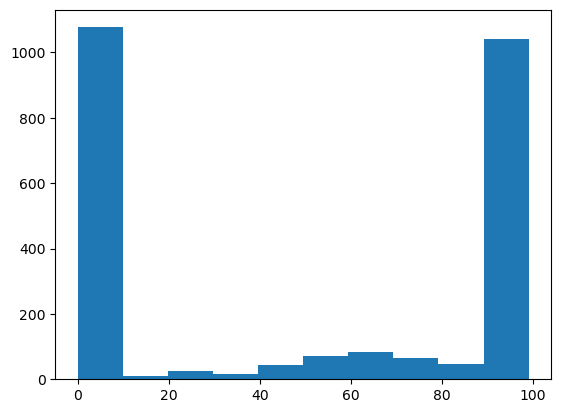

In [80]:
plt.hist(np.where(deltas_samples==1)[0])

### Delta estimator

In [26]:
G = int((n_steps-burnin)//thin)

In [27]:
q = np.zeros((T, T))
for ii in range(G):
    q = q + (etas_samples[:, ii] == etas_samples[: , ii][:, None]).astype(int)
q = q / n_steps
    

In [28]:
q

array([[0.06666667, 0.0666    , 0.06633333, ..., 0.        , 0.        ,
        0.        ],
       [0.0666    , 0.06666667, 0.0664    , ..., 0.        , 0.        ,
        0.        ],
       [0.06633333, 0.0664    , 0.06666667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.06666667, 0.06666667,
        0.06666667],
       [0.        , 0.        , 0.        , ..., 0.06666667, 0.06666667,
        0.06666667],
       [0.        , 0.        , 0.        , ..., 0.06666667, 0.06666667,
        0.06666667]])

In [29]:
np.argmin(np.array([1,2,0,2,3,4]))

2

In [30]:
a = 5
prova = [0,1,2,3,4,5,6,7,8,9,10]
prova[1:5-1]

[1, 2, 3]

In [31]:
#Steps --> start from [1,0,0,0,0,0,0] --> try to change all from 2:T --> then try to swap two consecutives
def delta_estimator(q, T):
    delta_final = np.zeros(T)
    delta_final[0] = 1
    eta_final = np.cumsum(delta_final)

    min_loss = np.sum(np.abs((eta_final == eta_final[:, None]).astype(int) - q))

    can_add_drop, can_swap = True, True

    counter = 0
    while can_add_drop or can_swap:
        print(counter)
        counter += 1
        candidates = np.arange(1, T)
        losses = np.zeros(len(candidates))

        for index in candidates:
            delta_candidate = delta_final.copy()
            delta_candidate[index] = 1 - delta_candidate[index]
            eta_candidate = np.cumsum(delta_candidate)
            loss = np.sum(np.abs((eta_candidate == eta_candidate[:, None]).astype(int) - q))
            losses[index-1]=loss

        if np.min(losses) < min_loss:
            min_loss = np.min(losses)
            delta_final[np.argmin(losses)+1] = 1 - delta_final[np.argmin(losses)+1]
            can_add_drop = True
            print("switched ", np.argmin(losses) + 1)
            print("Now: ", delta_final, "\n")
        else:
            can_add_drop = False
            print("Can't add")

        if np.sum(delta_final) in np.arange(2, T-1):
            candidates = np.where((delta_final[1:(T-1)] - delta_final[2:T]) != 0)[0] + 1
            print("swapping candidates are: ", candidates)
            losses = np.zeros(len(candidates))
            for i, candidate in enumerate(candidates):
                delta_candidate = delta_final.copy()
                delta_candidate[candidate], delta_candidate[candidate + 1] = delta_candidate[candidate + 1], delta_candidate[candidate]
                eta_candidate = np.cumsum(delta_candidate)
                loss = np.sum(np.abs((eta_candidate == eta_candidate[:, None]).astype(int) - q))
                losses[i] = loss
            if np.min(losses) < min_loss:
                min_loss = np.min(losses)
                delta_final[candidates[np.argmin(losses)]] =  1 - delta_final[candidates[np.argmin(losses)]]
                delta_final[candidates[np.argmin(losses)] + 1] = 1-delta_final[candidates[np.argmin(losses)]+1]
                print("swapped ", candidate )
                can_swap = True
            else:
                can_swap = False
                print("can't swap")

    return delta_final



In [32]:
trial = (npr.uniform(0, 1, 100) < .1).astype(int)

In [33]:
qtrial = trial == trial[:, None][0]

In [34]:
npr.beta()

TypeError: beta() takes at least 2 positional arguments (0 given)